# Population model simulator - demo

## Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch as th
from simulator.population_model import PopulationModel
from simulator.multi_armed_bandits import EpsilonGreedy, UCB, simulate, orders_and_rate_per_day
from simulator.plotting import plot_average_rewards


## Generate a population model

The agents have the following features:
- **buy intention**: the intention of a client to buy the product, modeled using a Beta distribution with $\alpha=2$, $\beta=7$.
$\alpha$ models the number of successes and $\beta$ the number of failures. The default case assumes that the mean value is around 0.22, with a low variance. If you want the model to be more concentrated towards 1, set $\alpha > \beta$.
- **client**: whether the agent is a new or existing client, modeled using Bernoulli with a probability of $25\%$ that a client is an existing one.
- **visit count**: represents the number of visits and is modeled using a Negative Binomial. It has as parameters total_count (the number of total trials or failures after which the process stops) and probs (the probability of success). total_counts is set to 1 and probability of success is correlated with the buy_intention modeled by a Beta distribution

Each sampling from the population requires a given discount that the clients see at that moment.

In [ ]:
# initialize a population with the default parameters
pop_model = PopulationModel.init()

In [6]:
# customize the parameters for the distributions
alpha = 5.0 # must be float
beta = 5.0 # must be float
probs_client = 0.1
visits_total_count = 1

In [8]:
# initialize a population with the customized parameters
pop_model = PopulationModel.init(alpha=alpha,\
                                 beta=beta, \
                                 probs_client=probs_client, \
                                 visits_total_count=visits_total_count )

### Fit the model to have the desired buy rate

In [9]:
# 0.8% of clients buy something, change if a different target is needed
pop_model.fit(target = 0.008) 
pop_model.save_weights("new_weights.pth")

000000) ratio=0.402, loss=0.76  |  tensor([ 1.04,  0.38, -1.52, -1.60, -1.26, -0.22, -0.81,  1.74])
001000) ratio=0.223, loss=0.34  |  tensor([ 0.44,  0.81, -0.86, -2.06, -1.35,  0.21, -0.47,  2.22])
002000) ratio=0.117, loss=0.17  |  tensor([ 0.08,  0.66, -0.36, -2.27, -0.85,  0.06, -0.65,  2.79])
003000) ratio=0.060, loss=0.09  |  tensor([-0.27,  0.53,  0.10, -2.48, -0.34, -0.07, -0.90,  3.27])
004000) ratio=0.049, loss=0.07  |  tensor([-0.61,  0.45,  0.45, -2.65,  0.09, -0.15, -1.14,  3.68])
005000) ratio=0.033, loss=0.06  |  tensor([-0.91,  0.42,  0.73, -2.80,  0.50, -0.18, -1.32,  4.02])
006000) ratio=0.022, loss=0.05  |  tensor([-1.18,  0.41,  0.96, -2.95,  0.91, -0.19, -1.46,  4.30])
007000) ratio=0.012, loss=0.04  |  tensor([-1.42,  0.38,  1.12, -3.04,  1.25, -0.22, -1.58,  4.57])
008000) ratio=0.020, loss=0.05  |  tensor([-1.64,  0.37,  1.25, -3.14,  1.59, -0.23, -1.65,  4.79])
009000) ratio=0.024, loss=0.06  |  tensor([-1.80,  0.35,  1.33, -3.21,  1.87, -0.25, -1.68,  4.97])


### Population model with 0.8% buy rate

In [2]:
# load the pretrained weights for a population model that had 0.8% buy rate, with the default parameters
# pop_model.load_weights("weights_population_model_0.8_ratio.pth")


## Population model analysis

### The population model distribution for intention, visits count

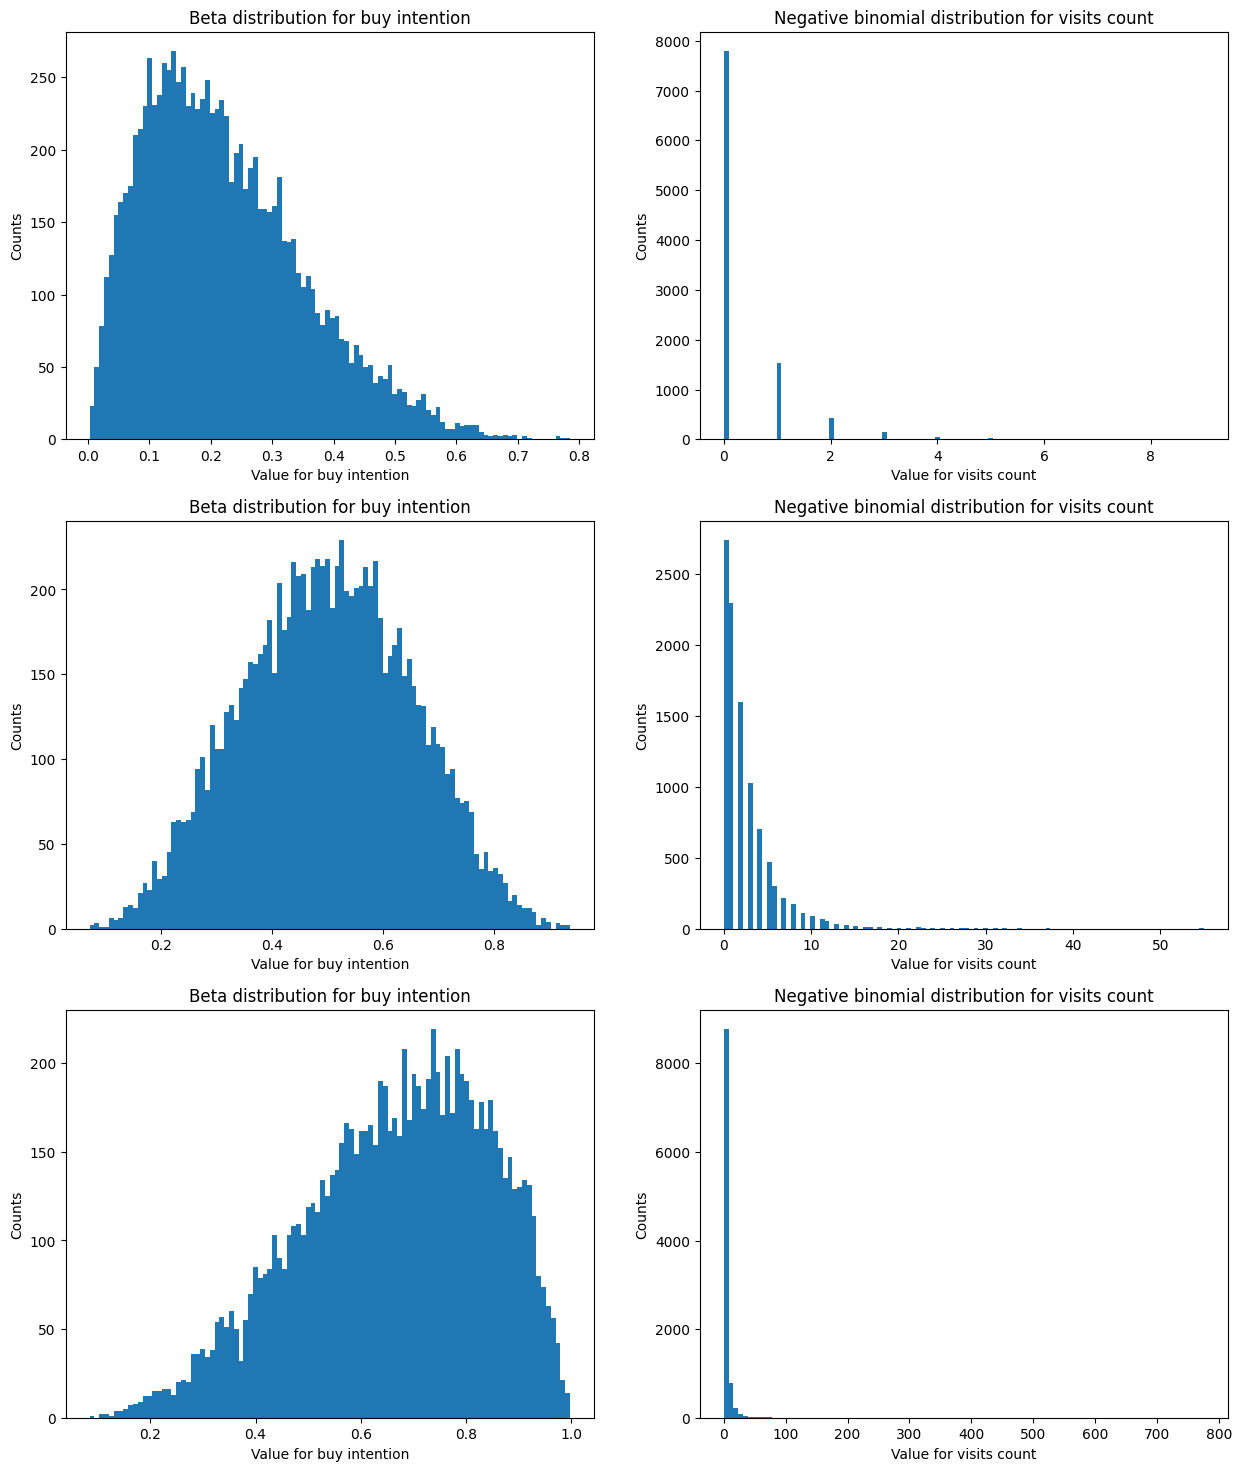

In [29]:
parameters_combinations = [
    {'alpha':2.0, 'beta':7.0, 'probs_client':0.25, 'visits_total_count':1},
    {'alpha':5.0, 'beta':5.0, 'probs_client':0.1, 'visits_total_count':2},
    {'alpha':4.0, 'beta':2.0, 'probs_client':0.5, 'visits_total_count':1}
]
fig, axes = plt.subplots(3, 2, figsize=(15, 18))  
for i, parameters in enumerate(parameters_combinations):
    pop_model = PopulationModel.init(alpha=parameters['alpha'],\
                                    beta=parameters['beta'], \
                                    probs_client=parameters['probs_client'], \
                                    visits_total_count=parameters['visits_total_count'] )

    sampled_features = pop_model.sample(discount=0.2, N=10000)
    intention_values = sampled_features[:, 0].detach().numpy()
    client_values = sampled_features[:, 1].detach().numpy()
    visits_count_values = sampled_features[:, 2].detach().numpy()

    axes[i,0].hist(intention_values, bins=100)
    axes[i,0].set_title("Beta distribution for buy intention")
    axes[i,0].set_xlabel("Value for buy intention")
    axes[i,0].set_ylabel("Counts")
    axes[i,1].hist(visits_count_values, bins=100)
    axes[i,1].set_title("Negative binomial distribution for visits count")
    axes[i,1].set_xlabel("Value for visits count")
    axes[i,1].set_ylabel("Counts")

### Buy decision rate function with respect to discount over 1000 samples

In [31]:
pop_model = PopulationModel.init()
pop_model.load_weights("weights_population_model_0.8_ratio.pth")

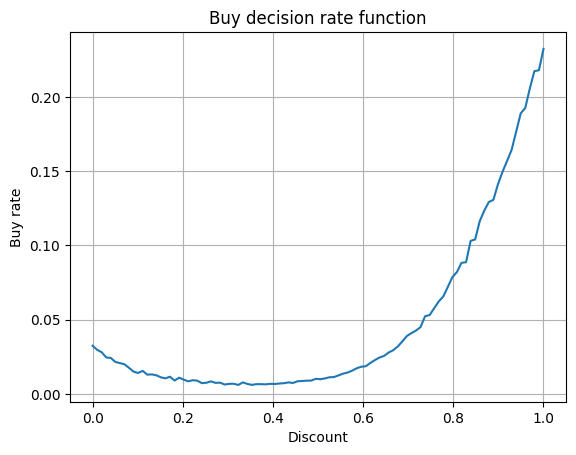

In [32]:
discounts = np.linspace(0.0, 1.0, 100)  

sigmoid_outputs = []

N = 1000

for discount in discounts:
    # sample N set of features with a specified discount 
    sampled_features = pop_model.sample(discount=discount, N=N)
    
    # create polynomial features for the samples 
    k = pop_model.weights.shape[0] // sampled_features.shape[1]  
    phi = pop_model._make_features(sampled_features, k)
    
    sigmoid_output = th.sigmoid(phi @ pop_model.weights).detach().numpy()
    
    # compute the mean of the sigmoid outputs for the N samples with the specified discount
    sigmoid_outputs.append(np.mean(sigmoid_output))

plt.plot(discounts, sigmoid_outputs)
plt.title("Buy decision rate function")
plt.xlabel("Discount")
plt.ylabel("Buy rate")
plt.grid(True)
plt.savefig("plots/new_buy_probability_correlated_with_discount.png")
plt.show()

### Buy decision rate function with respect to buy_intention and is_client over 1000 samples

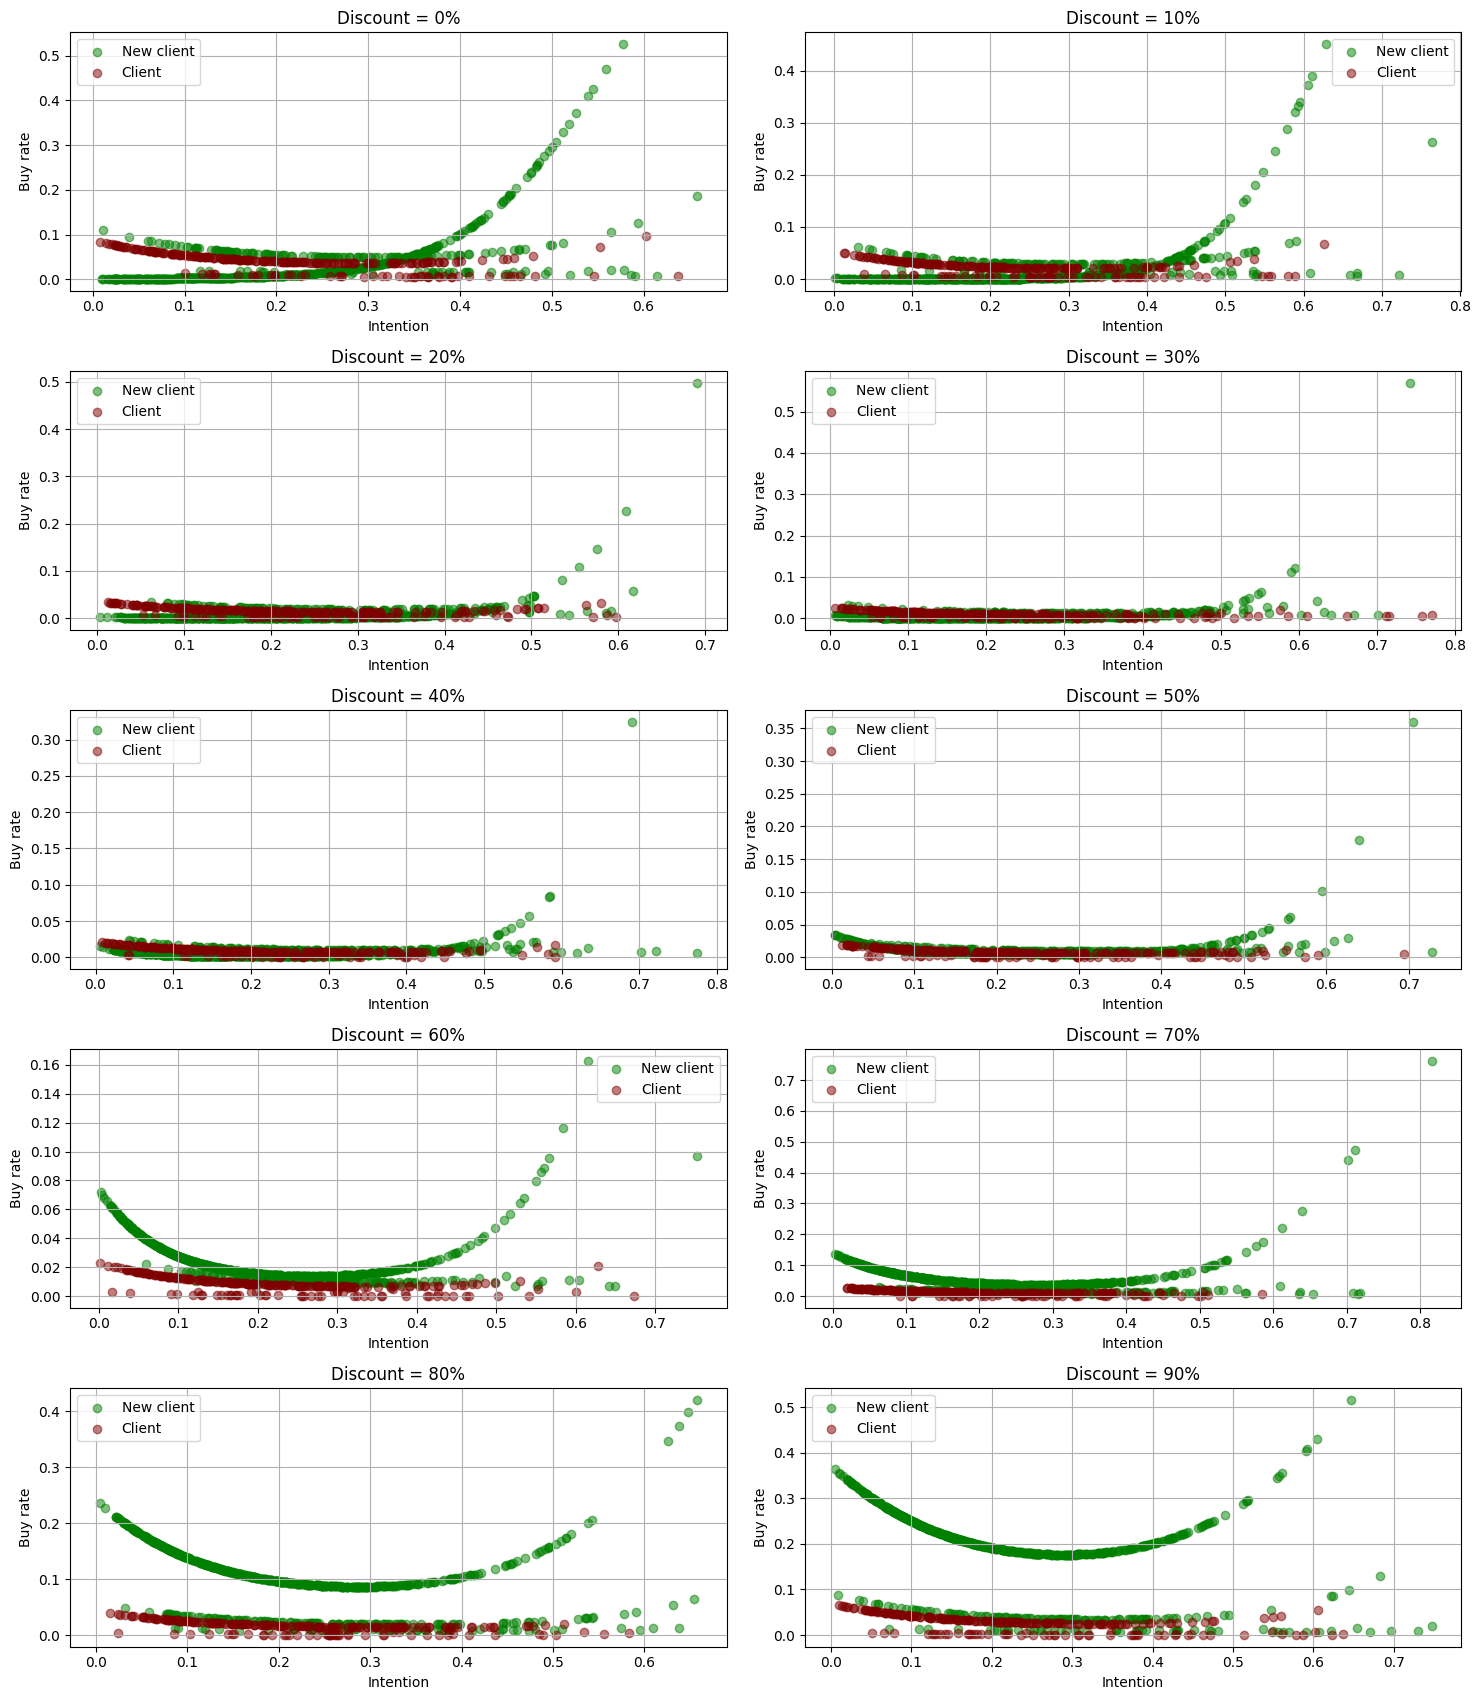

In [33]:
discounts = np.linspace(0.0, 0.9, 10)

fig, axes = plt.subplots(5, 2, figsize=(15, 18))  
axes = axes.flatten()

N = 1000  

for i, discount in enumerate(discounts):
    # sample N set of features with a specified discount 
    sampled_features = pop_model.sample(discount=discount, N=N)
    
    # extract the values for the features buy_intention and client (whether it's an existing client or not)
    intention_values = sampled_features[:, 0].detach().numpy()
    client_values = sampled_features[:, 1].detach().numpy()

    # create polynomial features for the samples 
    k = pop_model.weights.shape[0] // sampled_features.shape[1]
    phi = pop_model._make_features(sampled_features, k)
    sigmoid_outputs = th.sigmoid(phi @ pop_model.weights).detach().numpy()

    non_clients = client_values == 0
    clients = client_values == 1
    
    # plot for each discount the correlation between buy rate and buy intention, coloured by the client feature
    axes[i].scatter(intention_values[non_clients], sigmoid_outputs[non_clients], 
                    color='green', label='New client', alpha=0.5)
    axes[i].scatter(intention_values[clients], sigmoid_outputs[clients], 
                    color='maroon', label='Client', alpha=0.5)
    axes[i].set_title(f"Discount = {discount*100:.0f}%")
    axes[i].set_xlabel("Intention")
    axes[i].set_ylabel("Buy rate")
    axes[i].grid(True)
    axes[i].legend()


plt.tight_layout(rect=[0, 0, 1, 0.95])  
plt.savefig("plots/new_buy_probability_correlated_wth_intention_discount_and_client.png")
plt.show()